In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain

import pydicom

import glob

import matplotlib.image as image

from skimage import io

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
27935,00007282_000.png,No Finding,0,7282,35,M,PA,2500,2048,0.168,0.168,NaN
91366,00022810_002.png,No Finding,2,22810,11,F,AP,3056,2544,0.139,0.139,NaN
20672,00005532_009.png,Infiltration|Nodule|Pleural_Thickening,9,5532,39,F,PA,2492,2449,0.143,0.143,NaN


In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4702,00023943_000.png,No Finding,0,23943,032Y,M,PA,2500,2048,0.168,0.168
5514,00030079_032.png,Consolidation,32,30079,016Y,M,AP,3056,2544,0.139,0.139
5336,00028765_020.png,Infiltration,20,28765,032Y,F,AP,3056,2544,0.139,0.139


## EDA

In [4]:
# see type and null values on the data
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 481.9+ KB


In [105]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [106]:
# get the stat description
sample_df.describe()

,Follow-up #,Patient ID,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
count,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000
mean,8.616661,14330.617017,2644.795755,2491.087406,0.155467,0.155467
std,15.565815,8411.477789,347.188754,399.119063,0.016201,0.016201
min,0.000000,13.000000,1362.000000,966.000000,0.115000,0.115000
25%,0.000000,7289.000000,2500.000000,2048.000000,0.143000,0.143000
50%,3.000000,13993.000000,2542.000000,2544.000000,0.143000,0.143000
75%,10.000000,20655.500000,2992.000000,2991.000000,0.168000,0.168000
max,177.000000,30797.000000,3266.000000,3056.000000,0.198800,0.198800


In [107]:
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


In [108]:
# shape of the df
print('shape all NIH data:', all_xray_df.shape)


print('shape sample data:', sample_df.shape)

shape all NIH data: (112120, 12)
shape sample data: (5606, 11)


**Remarks**: There are 112120 row for all the data with 12 columns while the sample data has 5606 rows with 11 column. There is no missing values from the data which is great. 

However, it is found that from the stat description the max of patient age is 414 which shouldn't be correct.

We might want to drop unnamed 11 column since it has no values at all.

Next, we'll take a look at each column.

### Demographic and Rows Exploration

In [109]:
all_xray_df_copy = all_xray_df.copy()

### 1. Age

In [110]:
all_xray_df_copy['Patient Age'].nunique()

107

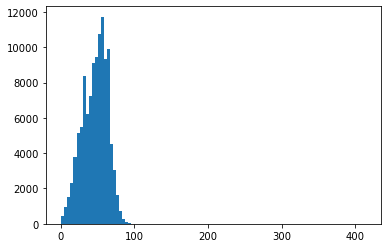

In [111]:
age_hist = plt.hist(all_xray_df['Patient Age'], bins = 100)

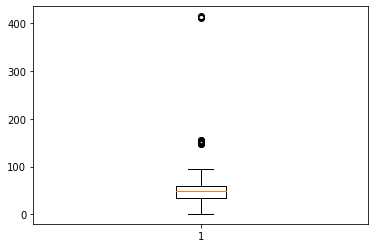

In [112]:
# boxplot to see age outliers
box_age = plt.boxplot(all_xray_df['Patient Age'])

**Remarks**: From the boxplot, there are ages that are over 100, which might be possible up to 100 something but there is also 400 as the age. So, we'll take a look at it below.

In [113]:
over_100 = all_xray_df[all_xray_df['Patient Age'] > 100].sort_values(by = 'Patient Age', ascending=False)
over_100

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,0.139,NaN
86264,00021275_003.png,No Finding,3,21275,413,F,AP,3056,2544,0.139,0.139,NaN
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,0.139,NaN
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,0.139,NaN
91369,00022811_000.png,No Finding,0,22811,412,M,PA,3056,2544,0.139,0.139,NaN
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139,NaN
101194,00026871_000.png,No Finding,0,26871,155,F,PA,2992,2991,0.143,0.143,NaN
104590,00027989_000.png,No Finding,0,27989,155,M,PA,2992,2991,0.143,0.143,NaN
98495,00026028_001.png,Atelectasis,1,26028,154,M,PA,2992,2991,0.143,0.143,NaN
95794,00025206_000.png,Infiltration|Mass,0,25206,153,M,PA,2992,2991,0.143,0.143,NaN


In [114]:
len(over_100)

16

**Remarks**: There are 16 data point that have age > 100. Since the unusual age is not that many and there might be some insight from that, we can set it into 101 so it's still within range and still use the data point for futher analysis.

In [115]:
all_xray_df_copy['Patient Age'] = all_xray_df_copy.apply(lambda x: 101 if x['Patient Age'] > 100 else x['Patient Age'], axis = 1)

In [116]:
# check again 
over_100_2 = all_xray_df_copy[all_xray_df_copy['Patient Age'] > 100].sort_values(by = 'Patient Age', ascending=False)
over_100_2

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
20852,00005567_000.png,Effusion|Pneumonia,0,5567,101,M,AP,3056,2544,0.139,0.139,NaN
46965,00011973_002.png,Edema,2,11973,101,M,AP,3056,2544,0.139,0.139,NaN
48284,00012238_010.png,No Finding,10,12238,101,M,PA,2992,2991,0.143,0.143,NaN
55742,00013950_000.png,No Finding,0,13950,101,M,PA,2964,2939,0.143,0.143,NaN
58650,00014520_026.png,Infiltration|Mass,26,14520,101,M,PA,2992,2991,0.143,0.143,NaN
62929,00015558_000.png,No Finding,0,15558,101,M,PA,2992,2991,0.143,0.143,NaN
74884,00018366_044.png,Pneumothorax,44,18366,101,F,PA,2302,2991,0.143,0.143,NaN
78795,00019346_000.png,Infiltration,0,19346,101,F,PA,2678,2774,0.143,0.143,NaN
84810,00020900_002.png,No Finding,2,20900,101,M,AP,3056,2544,0.139,0.139,NaN
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,101,M,AP,3056,2544,0.139,0.139,NaN


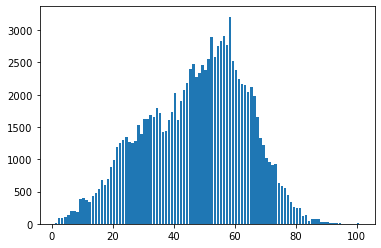

In [117]:
# the unusual patient age is not 101, let's take a look at the histogram again
age_hist_2 = plt.hist(all_xray_df_copy['Patient Age'], rwidth=0.8, bins=100)

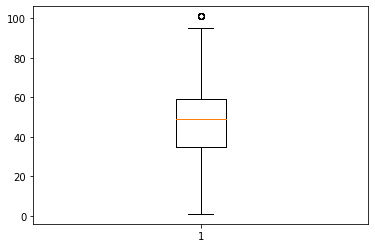

In [118]:
age_box_2 = plt.boxplot(all_xray_df_copy['Patient Age'])

In [119]:
all_xray_df_copy['Patient Age'].describe()

count    112120.000000
mean         46.880298
std          16.609556
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         101.000000
Name: Patient Age, dtype: float64

**Remarks**: The distribution is somewhat normal, but a left-skewed a little bit data. The peak is around 50 - 60. The boxplot and description show the range with mean 46 and median 49.

### 2. Gender

In [120]:
all_xray_df_copy['Patient Gender'].nunique()

2

<BarContainer object of 2 artists>

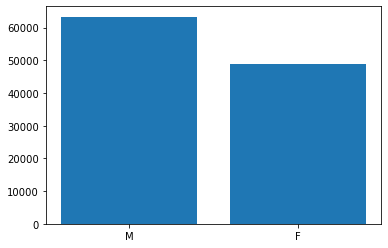

In [121]:
# gender plot
gender = all_xray_df_copy['Patient Gender'].value_counts().reset_index()

plt.bar(gender['index'], gender['Patient Gender'])

In [122]:
gender

,index,Patient Gender
0,M,63340
1,F,48780


**Remarks**: There is 64440 patients identified as male and 48780 patients identified as female.

### 3. View Position

In [123]:
# see unique values of view position column
all_xray_df_copy['View Position'].unique()

array(['PA', 'AP'], dtype=object)

<BarContainer object of 2 artists>

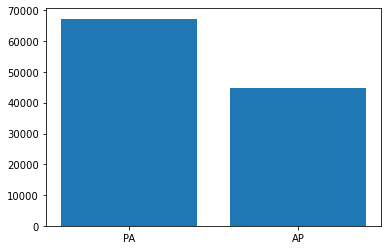

In [124]:
# view postion plot
view = all_xray_df_copy['View Position'].value_counts().reset_index()

plt.bar(view['index'], view['View Position'])

In [125]:
view

,index,View Position
0,PA,67310
1,AP,44810


**Remarks**: There are 67310 PA position and 44810 AP position in the data.

### 4. Follow-up number

In [126]:
# see unique values
all_xray_df_copy['Follow-up #'].nunique()

184

<BarContainer object of 184 artists>

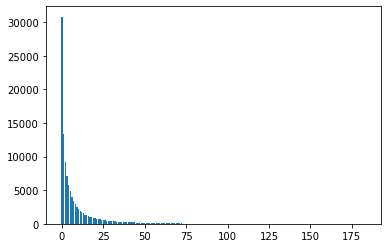

In [127]:
# view postion plot
followup = all_xray_df_copy['Follow-up #'].value_counts().reset_index()

plt.bar(followup['index'], followup['Follow-up #'])

In [128]:
followup

,index,Follow-up #
0,0,30805
1,1,13302
2,2,9189
3,3,7089
4,4,5759
...,...,...
179,181,1
180,174,1
181,180,1
182,178,1


In [129]:
all_xray_df_copy['Follow-up #'].describe()

count    112120.000000
mean          8.573751
std          15.406320
min           0.000000
25%           0.000000
50%           3.000000
75%          10.000000
max         183.000000
Name: Follow-up #, dtype: float64

**Remarks**: The minimum follow up is 0 and mostly is 0 (first visit). Maximum follow up number is 183 which may still make sense.

### 5. Finding Labels

Finding labels will be explore more on the next step since we want to focus on pneumonia thus we need to split the finding on this column.

In [130]:
all_xray_df_copy['Finding Labels'].nunique() 

836

In [131]:
all_xray_df_copy['Finding Labels'].value_counts() 

No Finding                                                     60361
Infiltration                                                    9547
Atelectasis                                                     4215
Effusion                                                        3955
Nodule                                                          2705
                                                               ...  
Infiltration|Pneumothorax|Atelectasis                              1
Effusion|Mass|Nodule|Pneumonia                                     1
Atelectasis|Consolidation|Edema|Effusion|Pleural_Thickening        1
Cardiomegaly|Edema|Effusion|Fibrosis|Infiltration                  1
Atelectasis|Hernia|Mass                                            1
Name: Finding Labels, Length: 836, dtype: int64

**Remarks**: There are 836 unique combination of the findings. No Finding is the most common label with 60361 cases and we can see that some of them only have 1 diagnosis.

In [132]:
# check the one with one diagnosis only
onediagnosis = all_xray_df_copy[all_xray_df_copy['Finding Labels'].apply(lambda x: ('|') not in x)]
onediagnosis

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112114,00030801_000.png,No Finding,0,30801,39,M,PA,2500,2048,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN


In [133]:
# see the number of unique diagnosis with set, updating the set by adding disctinct elements 
findings = set()
for f in all_xray_df_copy['Finding Labels'].unique():
    findings.update(f.split('|'))
print(f'number of unique diagnosis: {len(findings)}')
findings

number of unique diagnosis: 15


{'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax'}

**Remarks**: There 91324 data points out of 112120 that only have one diagnosis (may include the no finding as well) and there are 15 unique diagnosis listed on the data. 


### 6. Image width & height, pixel spacing

In [134]:
all_xray_df_copy['OriginalImage[Width'].describe()

count    112120.000000
mean       2646.078844
std         341.246429
min        1143.000000
25%        2500.000000
50%        2518.000000
75%        2992.000000
max        3827.000000
Name: OriginalImage[Width, dtype: float64

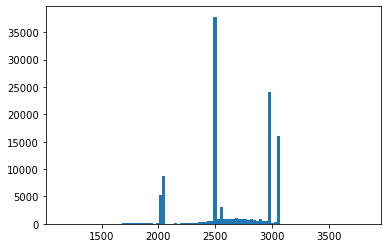

In [135]:
# histogram of image widht
hist_width = plt.hist(all_xray_df_copy['OriginalImage[Width'], bins = 100)

In [136]:
all_xray_df_copy['Height]'].describe()

count    112120.000000
mean       2486.438842
std         401.268227
min         966.000000
25%        2048.000000
50%        2544.000000
75%        2991.000000
max        4715.000000
Name: Height], dtype: float64

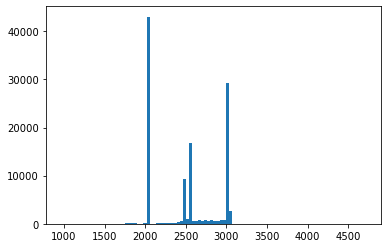

In [137]:
# histogram of image height
hist_height = plt.hist(all_xray_df_copy['Height]'], bins = 100)

In [138]:
all_xray_df_copy['OriginalImagePixelSpacing[x'].describe()

count    112120.000000
mean          0.155649
std           0.016174
min           0.115000
25%           0.143000
50%           0.143000
75%           0.168000
max           0.198800
Name: OriginalImagePixelSpacing[x, dtype: float64

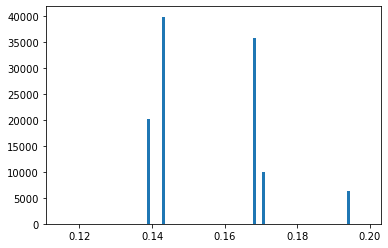

In [139]:
# histogram of pixel spacing x
hist_pix_x = plt.hist(all_xray_df_copy['OriginalImagePixelSpacing[x'], bins = 100)

In [140]:
all_xray_df_copy['y]'].describe()

count    112120.000000
mean          0.155649
std           0.016174
min           0.115000
25%           0.143000
50%           0.143000
75%           0.168000
max           0.198800
Name: y], dtype: float64

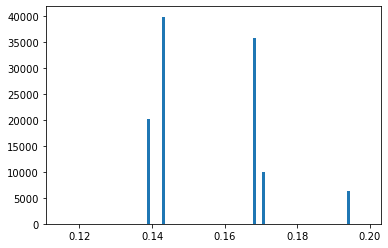

In [141]:
# histogram of pixel spacing y
hist_pix_y = plt.hist(all_xray_df_copy['y]'], bins = 100)

**Remarks**: Most image has height and widht around 2500. And most image has pixel x and y around 0.14 and 0.17

### 7. Patient ID

In [142]:
# check for duplicate values
all_xray_df_copy['Patient ID'].duplicated()

0         False
1          True
2          True
3         False
4         False
          ...  
112115     True
112116    False
112117    False
112118    False
112119    False
Name: Patient ID, Length: 112120, dtype: bool

In [143]:
unique_patients_id = all_xray_df_copy['Patient ID'].nunique()
unique_patients_id

30805

In [144]:
print(f'average number records per patient: {len(all_xray_df_copy)/unique_patients_id :.2f}')
 

average number records per patient: 3.64


In [145]:
count_id = all_xray_df_copy['Patient ID'].value_counts().reset_index()
count_id

,index,Patient ID
0,10007,184
1,13670,173
2,15530,158
3,12834,157
4,13993,143
...,...,...
30800,3301,1
30801,5350,1
30802,7399,1
30803,19693,1


In [146]:
(count_id[count_id['Patient ID'] > 1]).count()

index         13302
Patient ID    13302
dtype: int64

**Remarks**: There are 30805 patients and it can be duplicated since one patient can come many times, the average record per patient is 3.64 in the data and mostly only come once.

### Number of Cases
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases

In [147]:
new_df = all_xray_df_copy.copy()

In [148]:
# Here I'm going to split up my "Finding Labels" column so that I have one column in my dataframe per disease, with a binary flag.
# reference: exploring metadata lesson

all_labels = np.unique(list(chain(*new_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        new_df[c_label] = new_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
new_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1983,00000506_019.png,Effusion,19,506,28,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67072,00016577_004.png,Consolidation|Infiltration,4,16577,58,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
82402,00020274_018.png,No Finding,18,20274,52,F,AP,3024,2004,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [149]:
new_df.shape

(112120, 27)

In [150]:
new_df[all_labels].sum()/len(new_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

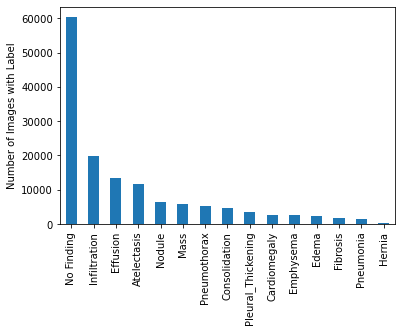

In [151]:
ax = new_df[all_labels].sum().sort_values(ascending = False).plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

**Remarks**: Above, I see the relative frequencies of each disease in the dataset. It looks like 'No Finding' is the most common occurrence. 'No Finding' can never appear with any other label by definition, so we know that in 53.8% of this dataset, there is no finding in the image. In addition to that, it appears that 'Infiltration' is the most common disease-related label, and it is followed by 'Effusion' and 'Atelectasis.' 

While pneumonia is the second least common disease in the dataset.

In [152]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [153]:
# all finding cases
all_findings = new_df[new_df["No Finding"] == 0]

# pneumonia and other diseases cases
pneumonia = new_df[new_df['Pneumonia'] == 1]
print(f'Pneumonia images: {len(pneumonia)} ({100.0*len(pneumonia)/len(new_df) :.2f}% of all data)')
print(f'Pneumonia images: {len(pneumonia)} ({100.0*len(pneumonia)/len(all_findings) :.2f}% of findings)')

atelectasis = new_df[new_df['Atelectasis'] == 1]
print(f'Atelectasis images: {len(atelectasis)} ({100.0*len(atelectasis)/len(new_df) :.2f}% of all data)')
print(f'Atelectasis images: {len(atelectasis)} ({100.0*len(atelectasis)/len(all_findings) :.2f}% of findings)')

cardiomegaly = new_df[new_df['Cardiomegaly'] == 1]
print(f'cardiomegaly images: {len(cardiomegaly)} ({100.0*len(cardiomegaly)/len(new_df) :.2f}% of all data)')
print(f'cardiomegaly images: {len(cardiomegaly)} ({100.0*len(cardiomegaly)/len(all_findings) :.2f}% of findings)')

consolidation = new_df[new_df['Consolidation'] == 1]
print(f'consolidation images: {len(consolidation)} ({100.0*len(consolidation)/len(new_df) :.2f}% of all data)')
print(f'consolidation images: {len(consolidation)} ({100.0*len(consolidation)/len(all_findings) :.2f}% of findings)')

edema = new_df[new_df['Edema'] == 1]
print(f'edema images: {len(edema)} ({100.0*len(edema)/len(new_df) :.2f}% of all data)')
print(f'edema images: {len(edema)} ({100.0*len(edema)/len(all_findings) :.2f}% of findings)')

effusion = new_df[new_df['Effusion'] == 1]
print(f'effusion images: {len(effusion)} ({100.0*len(effusion)/len(new_df) :.2f}% of all data)')
print(f'effusion images: {len(effusion)} ({100.0*len(effusion)/len(all_findings) :.2f}% of findings)')

emphysema = new_df[new_df['Emphysema'] == 1]
print(f'emphysema images: {len(emphysema)} ({100.0*len(emphysema)/len(new_df) :.2f}% of all data)')
print(f'emphysema images: {len(emphysema)} ({100.0*len(emphysema)/len(all_findings) :.2f}% of findings)')

fibrosis = new_df[new_df['Fibrosis'] == 1]
print(f'fibrosis images: {len(fibrosis)} ({100.0*len(fibrosis)/len(new_df) :.2f}% of all data)')
print(f'fibrosis images: {len(fibrosis)} ({100.0*len(fibrosis)/len(all_findings) :.2f}% of findings)')

hernia = new_df[new_df['Hernia'] == 1]
print(f'hernia images: {len(hernia)} ({100.0*len(hernia)/len(new_df) :.2f}% of all data)')
print(f'hernia images: {len(hernia)} ({100.0*len(hernia)/len(all_findings) :.2f}% of findings)')

infiltration = new_df[new_df['Infiltration'] == 1]
print(f'infiltration images: {len(infiltration)} ({100.0*len(infiltration)/len(new_df) :.2f}% of all data)')
print(f'infiltration images: {len(infiltration)} ({100.0*len(infiltration)/len(all_findings) :.2f}% of findings)')

mass = new_df[new_df['Mass'] == 1]
print(f'mass images: {len(mass)} ({100.0*len(mass)/len(new_df) :.2f}% of all data)')
print(f'mass images: {len(mass)} ({100.0*len(mass)/len(all_findings) :.2f}% of findings)')

nodule = new_df[new_df['Nodule'] == 1]
print(f'nodule images: {len(nodule)} ({100.0*len(nodule)/len(new_df) :.2f}% of all data)')
print(f'nodule images: {len(nodule)} ({100.0*len(nodule)/len(all_findings) :.2f}% of findings)')

pleural_Thickening = new_df[new_df['Pleural_Thickening'] == 1]
print(f'pleural_Thickening images: {len(pleural_Thickening)} ({100.0*len(pleural_Thickening)/len(new_df) :.2f}% of all data)')
print(f'pleural_Thickening images: {len(pleural_Thickening)} ({100.0*len(pleural_Thickening)/len(all_findings) :.2f}% of findings)')

pneumothorax = new_df[new_df['Pneumothorax'] == 1]
print(f'pneumothorax images: {len(pneumothorax)} ({100.0*len(pneumothorax)/len(new_df) :.2f}% of all data)')
print(f'pneumothorax images: {len(pneumothorax)} ({100.0*len(pneumothorax)/len(all_findings) :.2f}% of findings)')



Pneumonia images: 1431 (1.28% of all data)
Pneumonia images: 1431 (2.76% of findings)
Atelectasis images: 11559 (10.31% of all data)
Atelectasis images: 11559 (22.33% of findings)
cardiomegaly images: 2776 (2.48% of all data)
cardiomegaly images: 2776 (5.36% of findings)
consolidation images: 4667 (4.16% of all data)
consolidation images: 4667 (9.02% of findings)
edema images: 2303 (2.05% of all data)
edema images: 2303 (4.45% of findings)
effusion images: 13317 (11.88% of all data)
effusion images: 13317 (25.73% of findings)
emphysema images: 2516 (2.24% of all data)
emphysema images: 2516 (4.86% of findings)
fibrosis images: 1686 (1.50% of all data)
fibrosis images: 1686 (3.26% of findings)
hernia images: 227 (0.20% of all data)
hernia images: 227 (0.44% of findings)
infiltration images: 19894 (17.74% of all data)
infiltration images: 19894 (38.44% of findings)
mass images: 5782 (5.16% of all data)
mass images: 5782 (11.17% of findings)
nodule images: 6331 (5.65% of all data)
nodule 

In [154]:
no_pneumonia = new_df[new_df["Pneumonia"] == 0]
print(f'No pneumonia finding: {len(no_pneumonia)}')

No pneumonia finding: 110689


**Remakrks**: Pneumonia accounts for 1.28% from all the dataset and 2.76 from the data that has findings. From all data, there are 110689 data points where there is no pneumonia.

### Demographic exploration with pnuemonia case

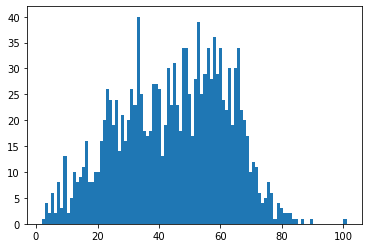

In [155]:
# age
pn_hist = plt.hist(pneumonia['Patient Age'], bins=100)

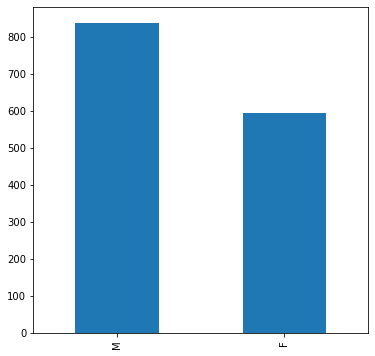

In [156]:
# gender
plt.figure(figsize=(6,6))
pneumonia['Patient Gender'].value_counts().plot(kind='bar')

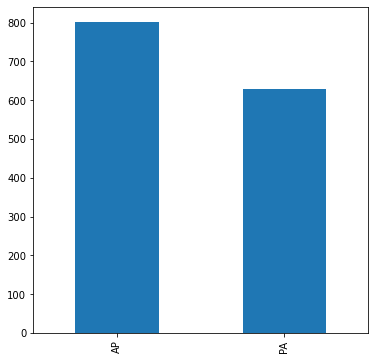

In [157]:
# view position
plt.figure(figsize=(6,6))
pneumonia['View Position'].value_counts().plot(kind='bar')

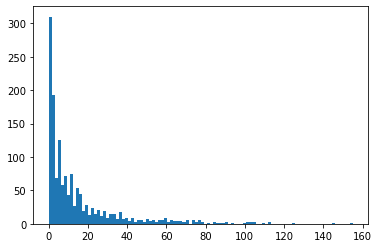

In [158]:
# follow up
pn_folllwup = plt.hist(pneumonia['Follow-up #'], bins=100)

In [159]:
# patient id
pneumonia_patients = pneumonia['Patient ID'].nunique()
print(f'Total pneumonia patients: {pneumonia_patients}, average number records per patient: {len(pneumonia)/pneumonia_patients :.2f}')
  

Total pneumonia patients: 1008, average number records per patient: 1.42


**Remarks**: the age distribution of pneumonia is more or less the same as the general one, as well as the proportion of male. Total pneumonia patients ar 1008 with average record 1.42

### Distribution of penumonia comorbid

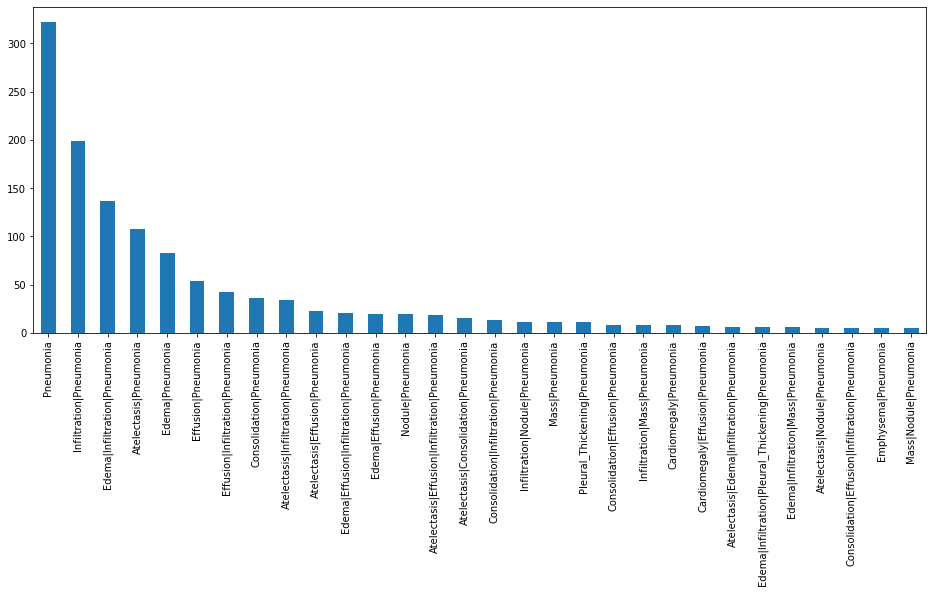

In [160]:
# check the first 30 pneumonia label
plt.figure(figsize=(16,6))
new_df[new_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

**Remarks**: It looks like Pneumonia actually occurs alone for the most part, and that its most-common comorbidities are Infiltration and Edema. 

In [161]:
new_df[new_df['Pneumonia']==1]['Finding Labels'].value_counts()[0:30]

Pneumonia                                          322
Infiltration|Pneumonia                             199
Edema|Infiltration|Pneumonia                       137
Atelectasis|Pneumonia                              108
Edema|Pneumonia                                     83
Effusion|Pneumonia                                  54
Effusion|Infiltration|Pneumonia                     42
Consolidation|Pneumonia                             36
Atelectasis|Infiltration|Pneumonia                  34
Atelectasis|Effusion|Pneumonia                      23
Edema|Effusion|Infiltration|Pneumonia               21
Edema|Effusion|Pneumonia                            19
Nodule|Pneumonia                                    19
Atelectasis|Effusion|Infiltration|Pneumonia         18
Atelectasis|Consolidation|Pneumonia                 15
Consolidation|Infiltration|Pneumonia                13
Infiltration|Nodule|Pneumonia                       11
Mass|Pneumonia                                      11
Pleural_Th

**Remarks**: Thereare 322 cases of pneumonia label only, followed by infiltraion + pneumonia which accounts for 199 cases. We'll take a look at pneumonia and its comorbid.

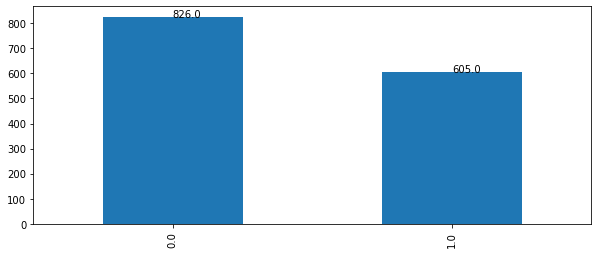

In [162]:
# count where pneumonia and infiltraion occurs together
plt.figure(figsize=(10,4))
ax = new_df[new_df.Pneumonia ==1]["Infiltration"].value_counts().plot(kind='bar')

for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))


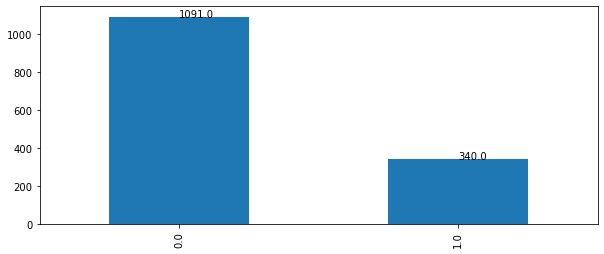

In [163]:
# count where pneumonia and edema occurs together
plt.figure(figsize=(10,4))
ax = new_df[new_df.Pneumonia ==1]["Edema"].value_counts()[0:30].plot(kind='bar')

for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

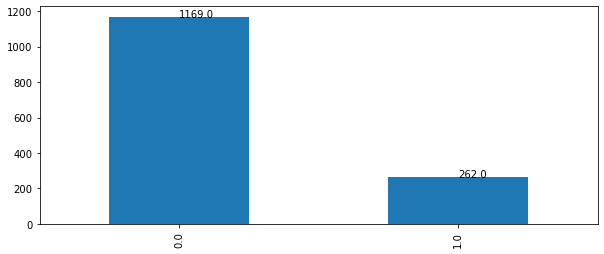

In [164]:
# count where pneumonia and atelectasis occurs together
plt.figure(figsize=(10,4))
ax = new_df[new_df.Pneumonia ==1]["Atelectasis"].value_counts()[0:30].plot(kind='bar')

for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

**Remarks**: From the top 3 comorbid that occurs with pneumonia: Effusion, Edema, and Atelectasis, from most of the data, it shows that more often they are not found together.

### Number of disease per patient

In [165]:
new_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [166]:
# copy the df for this purpose only so doesn't change the df
new_df_copy = new_df.copy()

In [167]:
# copy the labels to drop the no finding
all_labels_copy = all_labels.copy()

In [168]:
all_labels_copy.remove('No Finding')

In [169]:
all_labels_copy

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [170]:
# sum all the disease per patient
new_df_copy["number_disease"] = new_df_copy.apply(lambda x: sum(x[all_labels_copy]), axis=1)

In [171]:
new_df_copy.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,number_disease
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [172]:
# groupby patient to get total number of disease
patient_disease_sum = new_df_copy['number_disease'].groupby(new_df_copy['Patient ID']).sum().reset_index()
patient_disease_sum

,Patient ID,number_disease
0,1,5.0
1,2,0.0
2,3,9.0
3,4,2.0
4,5,3.0
...,...,...
30800,30801,2.0
30801,30802,0.0
30802,30803,0.0
30803,30804,0.0


In [173]:
patient_disease_sum.describe()

,Patient ID,number_disease
count,30805.000000,30805.000000
mean,15403.000000,2.635157
std,8892.781858,8.477279
min,1.000000,0.000000
25%,7702.000000,0.000000
50%,15403.000000,0.000000
75%,23104.000000,2.000000
max,30805.000000,254.000000


In [174]:
# example of patient with the least diseases
new_df_copy[new_df_copy['Patient ID'] == 30802]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,number_disease
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


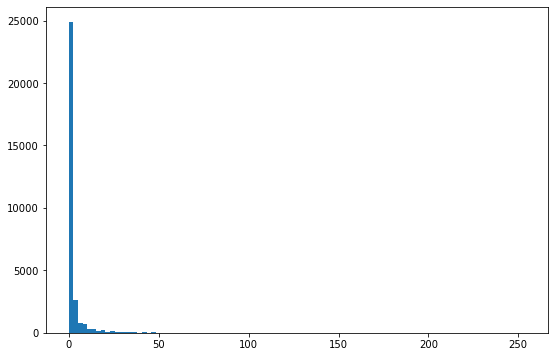

In [175]:
# histogram of # of diseases 
plt.figure(figsize = (9,6))
disease_hist = plt.hist(patient_disease_sum['number_disease'], bins=100)

**Remarks**: From the histogram, mostly patient has 1 disease, the distribution is skewed to the right. Minimum disease found is 1 per patient while the maximum is 254, and the median is 1 which also showsthat most patient only has 1 disease.

The grouping only based on patients' ID not including their follow up, thus if they come to followup with the same (and multiple) disease, it will be added to their previous sum of disease.

### Correlation between features

In [176]:
corr = new_df.corr()

corr.style.background_gradient()


/opt/conda/lib/python3.7/site-packages/pandas/io/formats/style.py:1089: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/opt/conda/lib/python3.7/site-packages/pandas/io/formats/style.py:1090: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Follow-up #,1.000000,-0.026528,-0.028611,0.039551,-0.127636,0.017533,0.017533,nan,0.032771,0.024579,0.104930,0.066882,0.118701,0.047610,-0.006138,-0.014788,0.139787,0.010883,-0.176143,-0.001697,0.030354,0.043214,0.100756
Patient ID,-0.026528,1.000000,-0.042193,0.222263,0.193855,-0.218915,-0.218915,nan,0.011318,-0.014969,0.002159,0.007566,0.036546,0.008359,-0.043143,-0.009114,0.062451,0.024151,-0.051920,0.020814,0.006159,0.000506,0.035959
Patient Age,-0.028611,-0.042193,1.000000,0.087488,0.016681,0.003802,0.003802,nan,0.073700,0.003719,-0.002829,-0.012532,0.063383,0.031416,0.043345,0.044287,-0.019212,0.026180,-0.073697,0.038234,0.037772,-0.014857,-0.005412
OriginalImage[Width,0.039551,0.222263,0.087488,1.000000,0.587006,-0.832195,-0.832195,nan,0.039877,-0.009761,0.010374,0.008341,0.034685,0.008118,-0.002489,0.001704,0.052725,0.015382,-0.065200,0.016250,0.010112,0.007530,0.016391
Height],-0.127636,0.193855,0.016681,0.587006,1.000000,-0.797572,-0.797572,nan,-0.023683,-0.008102,-0.055080,-0.076384,-0.013175,-0.000570,0.033526,0.013789,-0.019105,0.011615,0.011856,0.027612,0.033503,-0.012555,0.035296
OriginalImagePixelSpacing[x,0.017533,-0.218915,0.003802,-0.832195,-0.797572,1.000000,1.000000,nan,-0.007394,0.001341,0.012543,0.020756,-0.017808,0.002984,-0.012495,-0.004344,-0.034363,-0.010241,0.035861,-0.019272,-0.019771,-0.004350,-0.018155
y],0.017533,-0.218915,0.003802,-0.832195,-0.797572,1.000000,1.000000,nan,-0.007394,0.001341,0.012543,0.020756,-0.017808,0.002984,-0.012495,-0.004344,-0.034363,-0.010241,0.035861,-0.019272,-0.019771,-0.004350,-0.018155
Unnamed: 11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Atelectasis,0.032771,0.011318,0.073700,0.039877,-0.023683,-0.007394,-0.007394,nan,1.000000,0.015819,0.108943,-0.003397,0.172445,0.032599,0.011130,0.010830,0.093131,0.018953,-0.366126,-0.007967,0.025202,0.029911,0.031422
Cardiomegaly,0.024579,-0.014969,0.003719,-0.009761,-0.008102,0.001341,0.001341,nan,0.015819,1.000000,0.015360,0.028318,0.130094,-0.007090,0.004837,0.001762,0.014189,-0.010682,-0.172067,-0.012123,0.009121,0.002848,-0.022248


**remarks**: there is no strong correlation between diseases, however for the width and height there is strong negative correlation, the same for the pixels. Which means that when, for example, widht increases, height decreases. 

### Pixel level assesment

In [16]:
# example of one DICOM file and its contents 
dcm = pydicom.dcmread('test5.dcm')
dcm

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'CT'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'PA'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows       

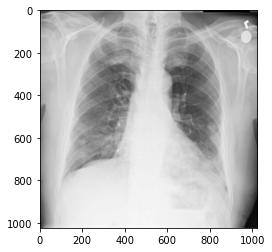

In [178]:
plt.imshow(dcm.pixel_array,cmap='gray')

In [179]:
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [180]:
# get pneumonia samples
pneumo_samples = sample_df[sample_df['Finding Labels'] == 'Pneumonia']
len(pneumo_samples)

14

In [181]:
pneumo_samples

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1631,00008470_008.png,Pneumonia,8,8470,030Y,F,AP,2500,2048,0.171,0.171
2286,00011702_043.png,Pneumonia,43,11702,026Y,F,AP,2500,2048,0.168,0.168
2422,00012158_025.png,Pneumonia,25,12158,047Y,F,PA,2992,2991,0.143,0.143
2522,00012667_000.png,Pneumonia,0,12667,007Y,F,PA,1804,1685,0.143,0.143
2534,00012733_000.png,Pneumonia,0,12733,073Y,M,PA,2992,2991,0.143,0.143
2875,00014201_008.png,Pneumonia,8,14201,031Y,F,PA,2578,2845,0.143,0.143
3593,00017714_019.png,Pneumonia,19,17714,020Y,M,AP,3056,2544,0.139,0.139
3858,00019021_001.png,Pneumonia,1,19021,044Y,M,PA,2992,2991,0.143,0.143
4033,00019865_013.png,Pneumonia,13,19865,022Y,M,PA,2786,2739,0.143,0.143
4282,00021127_018.png,Pneumonia,18,21127,065Y,M,PA,2992,2991,0.143,0.143


In [182]:
# see the path to the images data as indicated as image index in sample_df
!ls /data

ARXIV_V5_CHESTXRAY.pdf	images_002  images_007	images_012
BBox_List_2017.csv	images_003  images_008	LOG_CHESTXRAY.pdf
Data_Entry_2017.csv	images_004  images_009	README_CHESTXRAY.pdf
FAQ_CHESTXRAY.pdf	images_005  images_010	test_list.txt
images_001		images_006  images_011	train_val_list.txt


In [183]:
# get the images paths
image_paths = {os.path.basename(x): x for x in glob.glob(os.path.join('/data','images*', '*', '*.png'))}

In [184]:
# add the path to the df
pneumo_samples['image_paths'] = pneumo_samples['Image Index'].map(image_paths.get)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [185]:
# check the additional column for path
pneumo_samples

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,image_paths
1631,00008470_008.png,Pneumonia,8,8470,030Y,F,AP,2500,2048,0.171,0.171,/data/images_004/images/00008470_008.png
2286,00011702_043.png,Pneumonia,43,11702,026Y,F,AP,2500,2048,0.168,0.168,/data/images_006/images/00011702_043.png
2422,00012158_025.png,Pneumonia,25,12158,047Y,F,PA,2992,2991,0.143,0.143,/data/images_006/images/00012158_025.png
2522,00012667_000.png,Pneumonia,0,12667,007Y,F,PA,1804,1685,0.143,0.143,/data/images_006/images/00012667_000.png
2534,00012733_000.png,Pneumonia,0,12733,073Y,M,PA,2992,2991,0.143,0.143,/data/images_006/images/00012733_000.png
2875,00014201_008.png,Pneumonia,8,14201,031Y,F,PA,2578,2845,0.143,0.143,/data/images_007/images/00014201_008.png
3593,00017714_019.png,Pneumonia,19,17714,020Y,M,AP,3056,2544,0.139,0.139,/data/images_008/images/00017714_019.png
3858,00019021_001.png,Pneumonia,1,19021,044Y,M,PA,2992,2991,0.143,0.143,/data/images_009/images/00019021_001.png
4033,00019865_013.png,Pneumonia,13,19865,022Y,M,PA,2786,2739,0.143,0.143,/data/images_009/images/00019865_013.png
4282,00021127_018.png,Pneumonia,18,21127,065Y,M,PA,2992,2991,0.143,0.143,/data/images_010/images/00021127_018.png


In [186]:
image_name = pneumo_samples['Image Index']
image_name.iloc[0]

'00008470_008.png'

In [187]:
# function to normalized image

def image_normalized(img):
    data = img.ravel()
    normalized = (data-np.mean(data))/(np.std(data))
    return normalized

In [188]:
# function to show images and intensity distribution
def image_show(img_data):
    f = plt.figure()
    f.set_figwidth(10)
    
    s1 = f.add_subplot(1, 2, 1)
    s1.set_title('Image')
    
    # python’s imshow to visualize medical images during EDA
    plt.imshow(img_data, cmap='gray')
    
    s2 = f.add_subplot(1, 2, 2)
    s2.set_title('Intensity Distribution')
    
    # normalized
    #img_data = image_normalized(img_data)
    
     # python’s imshow to visualize intensity distribution during EDA
    plt.hist(img_data.ravel(), bins = 256)
    
   
    plt.show()

### Pneumonia Image and Distribution

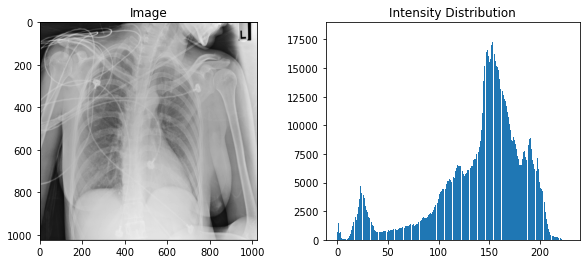

Image Name: 00008470_008.png


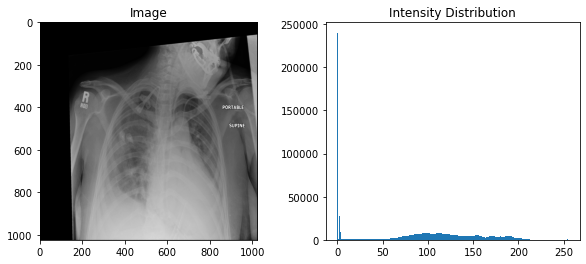

Image Name: 00011702_043.png


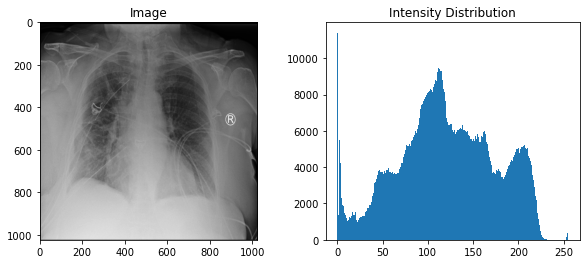

Image Name: 00028924_005.png


In [189]:
## create distributions of intensity values of the pixel-level data within images and compare them both within and across diagnoses
## use both of these methods of inspecting images to draw meaningful conclusions about what their model will train on

# example of image and histogram with AP position, female

example1 = io.imread('/data/images_004/images/' + image_name.iloc[0])

example2 = io.imread('/data/images_006/images/' + image_name.iloc[1])

example3 = io.imread('/data/images_012/images/' + image_name.iloc[-1])

image_show(example1)
print('Image Name:', image_name.iloc[0])

image_show(example2)
print('Image Name:', image_name.iloc[1])

image_show(example3)
print('Image Name:', image_name.iloc[-1])

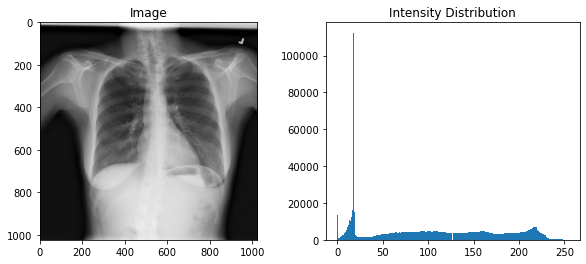

Image Name: 00012158_025.png


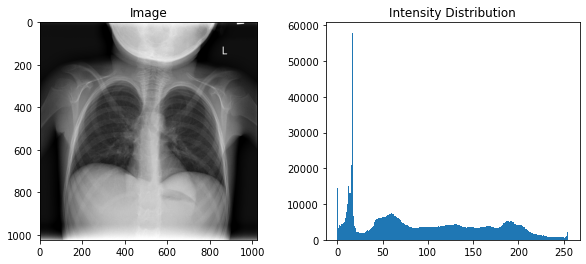

Image Name: 00012667_000.png


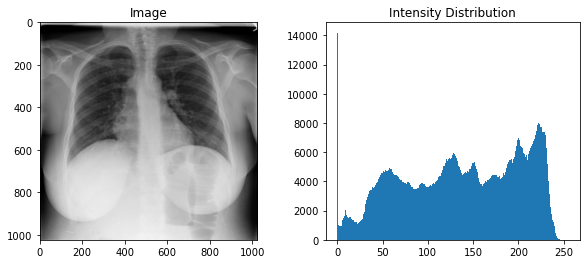

Image Name: 00014201_008.png


In [190]:
# example of image and histogram with PA position, female

example11 = io.imread('/data/images_006/images/' + image_name.iloc[2])

example22 = io.imread('/data/images_006/images/' + image_name.iloc[3])

example33 = io.imread('/data/images_007/images/' + image_name.iloc[5])

image_show(example11)
print('Image Name:', image_name.iloc[2])

image_show(example22)
print('Image Name:', image_name.iloc[3])

image_show(example33)
print('Image Name:', image_name.iloc[5])

### No Finding Image and Distribution

In [191]:
nofinding_sample = sample_df[sample_df['Finding Labels'] == 'No Finding'][0:30]
len(nofinding_sample)

30

In [192]:
nofinding_sample.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139000,0.139000
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139000,0.139000
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139000,0.139000
12,00000080_005.png,No Finding,5,80,067Y,F,PA,1884,2021,0.194311,0.194311


In [193]:
# add no finding image path to the df
nofinding_sample['image_paths'] = nofinding_sample['Image Index'].map(image_paths.get)
nofinding_sample.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,image_paths
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000017_001.png
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139000,0.139000,/data/images_001/images/00000042_002.png
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139000,0.139000,/data/images_001/images/00000057_001.png
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139000,0.139000,/data/images_001/images/00000061_019.png
12,00000080_005.png,No Finding,5,80,067Y,F,PA,1884,2021,0.194311,0.194311,/data/images_001/images/00000080_005.png
13,00000083_000.png,No Finding,0,83,056Y,F,PA,2048,2500,0.171000,0.171000,/data/images_001/images/00000083_000.png
17,00000099_006.png,No Finding,6,99,058Y,F,AP,2048,2500,0.168000,0.168000,/data/images_001/images/00000099_006.png
24,00000121_004.png,No Finding,4,121,054Y,M,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000121_004.png
28,00000165_008.png,No Finding,8,165,078Y,M,PA,2940,2900,0.143000,0.143000,/data/images_001/images/00000165_008.png
34,00000188_001.png,No Finding,1,188,045Y,M,PA,2698,2991,0.143000,0.143000,/data/images_001/images/00000188_001.png


In [194]:
image_name_nf = nofinding_sample['Image Index']

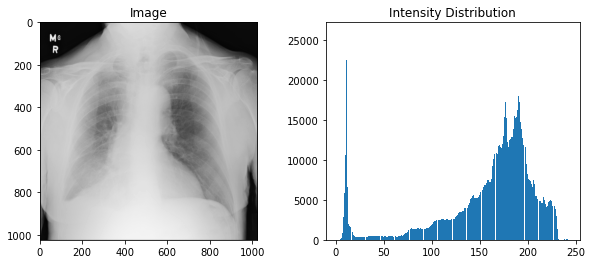

Image Name: 00000017_001.png


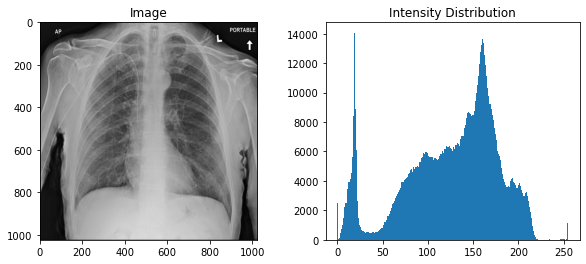

Image Name: 00000042_002.png


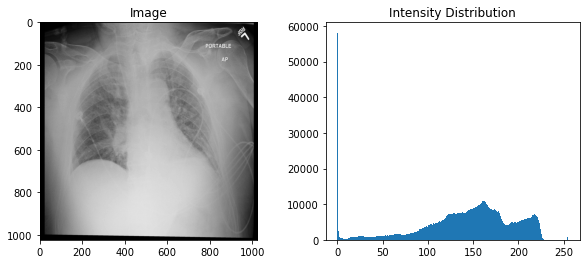

Image Name: 00000370_003.png


In [195]:
# example of no finding image and histogram with AP position

example_nf1 = io.imread('/data/images_001/images/' + image_name_nf.iloc[0])

example_nf2 = io.imread('/data/images_001/images/' + image_name_nf.iloc[1])

example_nf3 = io.imread('/data/images_001/images/' + image_name_nf.iloc[2])

image_show(example_nf1)
print('Image Name:', image_name_nf.iloc[0])

image_show(example_nf2)
print('Image Name:', image_name_nf.iloc[1])

image_show(example_nf3)
print('Image Name:', image_name_nf.iloc[-1])

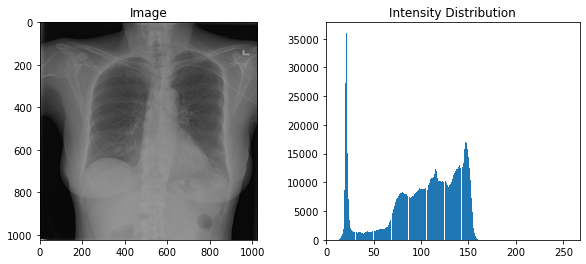

Image Name: 00000080_005.png


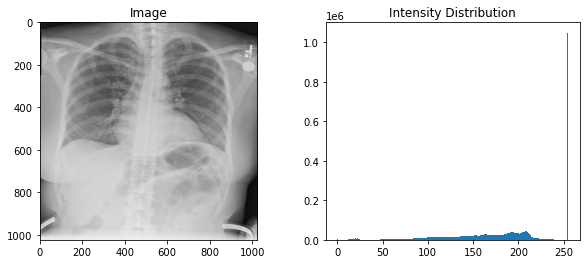

Image Name: 00000083_000.png


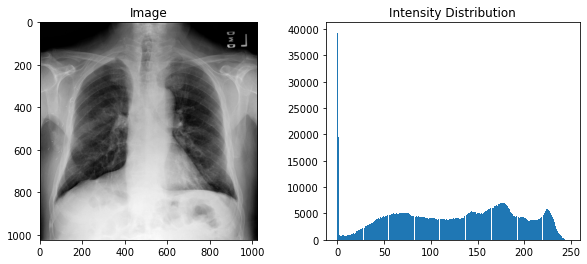

Image Name: 00000165_008.png


In [196]:
# example of no finding image and histogram with PA position

example_nf11 = io.imread('/data/images_001/images/' + image_name_nf.iloc[4])

example_nf22 = io.imread('/data/images_001/images/' + image_name_nf.iloc[5])

example_nf33 = io.imread('/data/images_001/images/' + image_name_nf.iloc[8])

image_show(example_nf11)
print('Image Name:', image_name_nf.iloc[4])

image_show(example_nf22)
print('Image Name:', image_name_nf.iloc[5])

image_show(example_nf33)
print('Image Name:', image_name_nf.iloc[8])

**Remarks**: 

It seems like most 'pneumonia' images have distribution peak between 50 and 100, though sometimes it's above 150, whereas 'no finding' images have peak at higher ('more light') values, around 150 and 200.

There are multiple spikes in these distributions which could be due to the presence of external entities.

### Remove Backrgound

In [197]:
# function to remove background with threshold
# function to show images distribution
def remove_background(img_data, thres):
    f = plt.figure()
    f.set_figwidth(12)
    
    s1 = f.add_subplot(1, 3, 1)
    s1.set_title('Image')
    
    # python’s imshow to visualize medical images during EDA
    plt.imshow(img_data, cmap='gray')
    
    img_mask = img_data > thres
    
    # background image
    s2 = f.add_subplot(1, 3, 2)
    s2.set_title('Background')
    plt.imshow(img_mask.astype(int)*255, cmap='gray')
    
    #intensity distribution
    s3 = f.add_subplot(1, 3, 3)
    s3.set_title('Intensity Distribution')
    
    plt.hist(img_data[img_mask], bins = 256, color='blue')
    
    plt.show()
    

### Remove background Pneumonia

In [198]:
background_threshold = 100

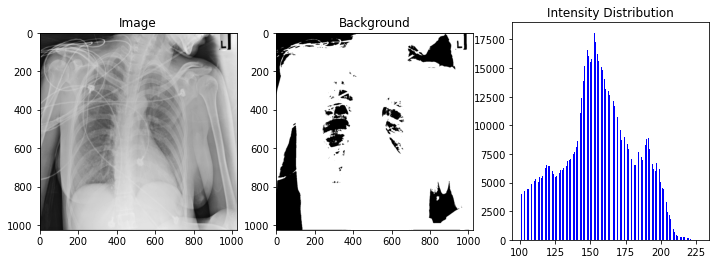

Image Name: 00008470_008.png


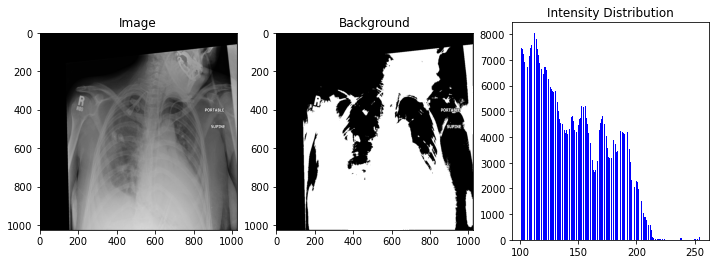

Image Name: 00011702_043.png


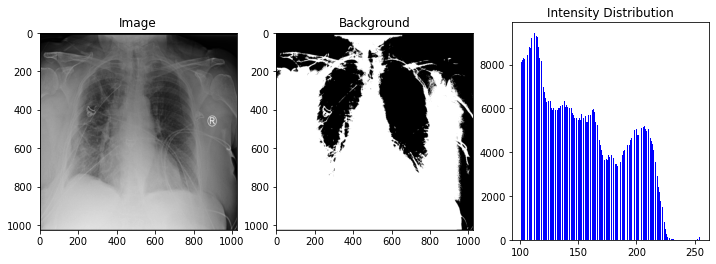

Image Name: 00028924_005.png


In [199]:
# example of image and histogram with AP position, female

ex1 = io.imread('/data/images_004/images/' + image_name.iloc[0])

ex2 = io.imread('/data/images_006/images/' + image_name.iloc[1])

ex3 = io.imread('/data/images_012/images/' + image_name.iloc[-1])

remove_background(ex1, background_threshold)
print('Image Name:', image_name.iloc[0])

remove_background(ex2, background_threshold)
print('Image Name:', image_name.iloc[1])

remove_background(ex3, background_threshold)
print('Image Name:', image_name.iloc[-1])

### Remove background No Finding

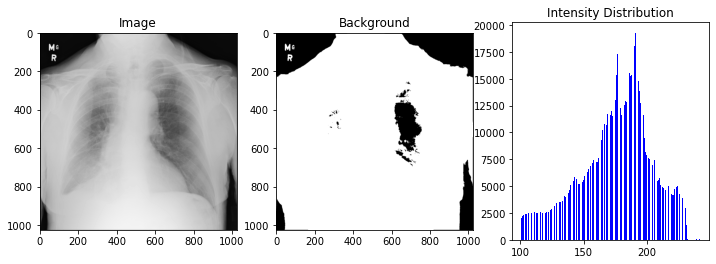

Image Name: 00000017_001.png


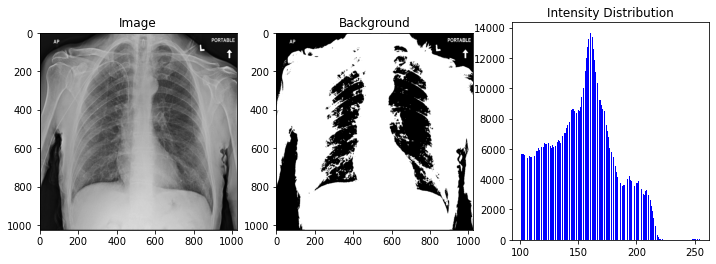

Image Name: 00000042_002.png


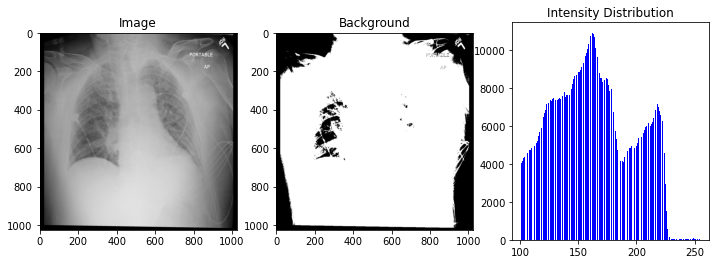

Image Name: 00000370_003.png


In [200]:
# example of no finding image and histogram with AP position

ex11 = io.imread('/data/images_001/images/' + image_name_nf.iloc[0])

ex22 = io.imread('/data/images_001/images/' + image_name_nf.iloc[1])

ex33 = io.imread('/data/images_001/images/' + image_name_nf.iloc[2])

remove_background(ex11, background_threshold)
print('Image Name:', image_name_nf.iloc[0])

remove_background(ex22, background_threshold)
print('Image Name:', image_name_nf.iloc[1])

remove_background(ex33, background_threshold)
print('Image Name:', image_name_nf.iloc[-1])

**Remarks**: The intensity distribution for 3 pneumonia cases shifted the peak to between 100 - 150 while for the no finding, the peak is similar which is between 150 -200.